### 0. Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer,  AdamW, Trainer, TrainingArguments
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [37]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\python_scripts\\nli_finetuning\\./src\\text_classification_functions.py'>

### Loading the Test split of the dataset

In [2]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,What does LLaMA means?,technology,2


... 214 records ...


,text,category,label
376,"how can I translate ""self-deprecating"" to Span...",language,2
379,"os.environ[""KERAS_BACKEND""] = ""jax"" # or ""ten...",coding,2
382,The only book I have read by Stanislaw Lem is ...,books,2


## Top-12 categories excluding "general knowledge"

In [3]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 15
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 12
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 15 prompt categories:
category
coding               33
technology           29
language             28
science              22
writing              20
business             14
popular culture      11
role play             9
riddle                9
general knowledge     8
ai                    8
finance               5
philosophy            4
politics              3
images                3
Name: count, dtype: int64
192 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 192
})
['coding', 'technology', 'language', 'science', 'writing', 'business', 'popular culture', 'role play', 'riddle', 'ai', 'finance', 'philosophy']


Instantiating the zero-shot classifiers:

In [4]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-shot classification examples:

In [5]:
text_sample = test_entailments_df.sample(1).text.values[0]
# text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: can bones  be dismembered by natural causes
labels: ['science', 'ai', 'riddle', 'philosophy', 'popular culture', 'writing', 'business', 'language', 'finance', 'technology', 'role play', 'coding']
scores: [0.282, 0.25, 0.231, 0.055, 0.035, 0.025, 0.025, 0.025, 0.02, 0.02, 0.017, 0.015]
Classification with base model:
sequence: can bones  be dismembered by natural causes
labels: ['riddle', 'ai', 'science', 'language', 'writing', 'popular culture', 'philosophy', 'technology', 'coding', 'finance', 'business', 'role play']
scores: [0.427, 0.343, 0.049, 0.035, 0.031, 0.028, 0.019, 0.018, 0.015, 0.014, 0.012, 0.01]


In [6]:
df_testing = test_entailments_df.sample(10).copy()
df_testing_zs = zs_classifier.classify_dataframe_column(df_testing, target_column = 'text', feature_suffix = 'zs')
# Add a column to indicate if the prediction was correct
df_testing_zs['is_correct'] = (
    df_testing_zs['category'] == df_testing_zs['top_class_zs']
).astype(int)
# Calculate accuracy of the sample:
sample_accuracy = df_testing_zs['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")
display(df_testing_zs)

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

Sample accuracy: 60.0%


,text,category,label,top_class_zs,top_score_zs,full_results_zs,is_correct
152,error: Namespace WebKit-6.0 could not be found,coding,2,technology,0.496,"[(technology, 0.496), (coding, 0.275), (ai, 0....",0
239,what are water molecules?,science,2,science,0.795,"[(science, 0.795), (riddle, 0.09), (ai, 0.036)...",1
75,please provide gnuplot code that will display ...,coding,2,coding,0.623,"[(coding, 0.623), (technology, 0.223), (scienc...",1
355,how many companies are included in each of tho...,business,2,finance,0.285,"[(finance, 0.285), (business, 0.259), (riddle,...",0
26,Can you make this link have color #353535 only...,coding,2,coding,0.366,"[(coding, 0.366), (technology, 0.213), (riddle...",1
93,Please identify whether Question 1 has the sam...,language,2,riddle,0.156,"[(riddle, 0.156), (language, 0.15), (science, ...",0
193,Rewrite the following into 3 sentences: Custom...,language,2,language,0.267,"[(language, 0.267), (business, 0.173), (writin...",1
118,Please identify whether Question 1 has the sam...,language,2,ai,0.228,"[(ai, 0.228), (language, 0.188), (riddle, 0.18...",0
267,Did EEG and fMRI experiments increase the numb...,science,2,science,0.392,"[(science, 0.392), (technology, 0.287), (philo...",1
203,Code to filter odd numbers in an array. Use c++,coding,2,coding,0.596,"[(coding, 0.596), (technology, 0.192), (writin...",1


Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 192/192 [00:44<00:00,  4.36it/s]


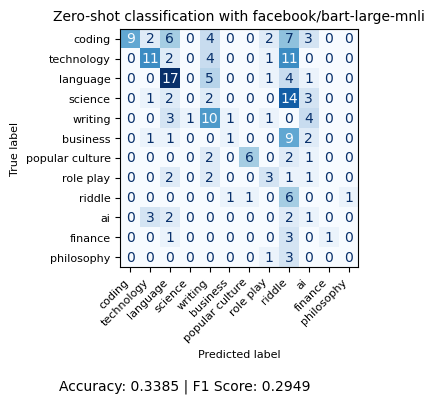

In [8]:
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 192/192 [00:43<00:00,  4.42it/s]


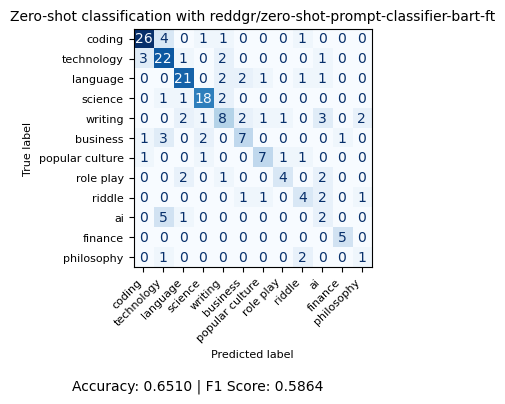

In [7]:
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

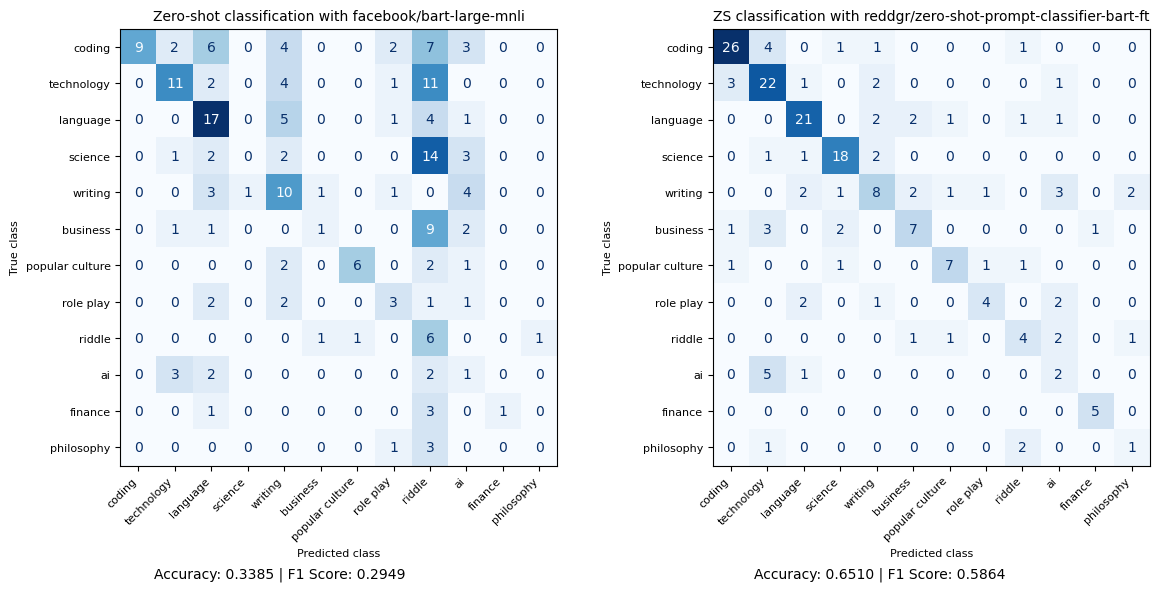

In [9]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

## Top-10 Categories

In [10]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 12
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 10
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
print(top_categories.to_list())

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

Top 12 prompt categories:
category
coding               33
technology           29
language             28
science              22
writing              20
business             14
popular culture      11
role play             9
riddle                9
general knowledge     8
ai                    8
finance               5
Name: count, dtype: int64
183 records for testing 10 categories
['coding', 'technology', 'language', 'science', 'writing', 'business', 'popular culture', 'role play', 'riddle', 'ai']


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 183/183 [08:50<00:00,  2.90s/it]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 183/183 [09:08<00:00,  3.00s/it]


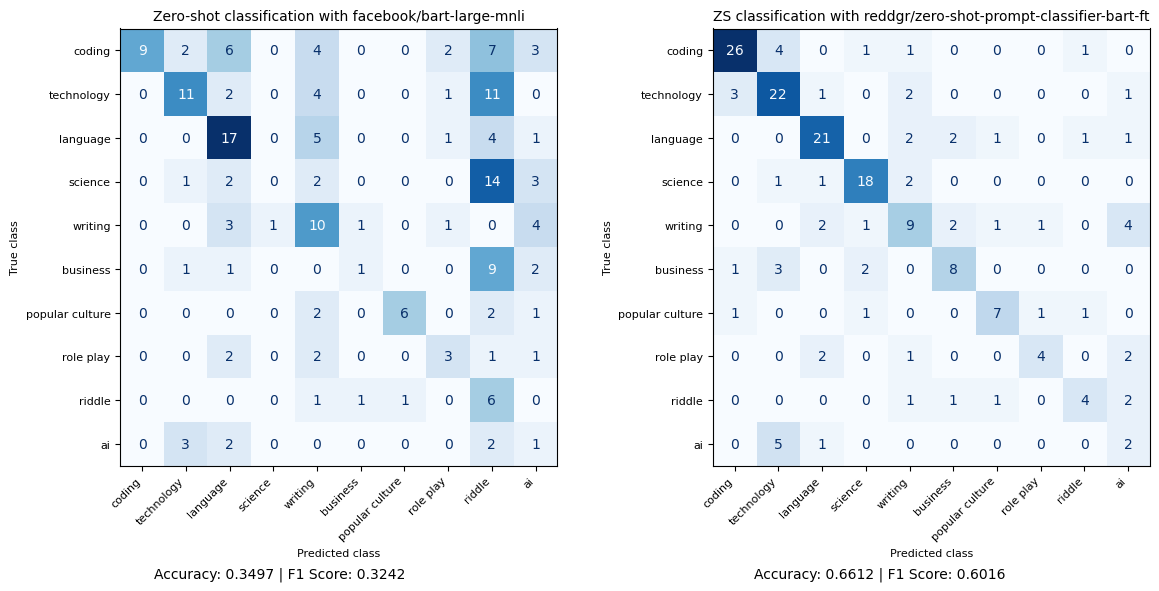

In [12]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

## 6 TTCB Grouped Categories

In [13]:
test_df_grouped = entailments_test_dataset_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'

In [20]:
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_categories.to_list())

Top 10 prompt categories:
category
language and writing         48
technology and ai            37
coding                       33
science                      22
business and finance         19
culture and entertainment    13
riddle                        9
role play                     9
general knowledge             8
philosophy                    4
Name: count, dtype: int64
172 records for testing 6 category groups
['language and writing', 'technology and ai', 'coding', 'science', 'business and finance', 'culture and entertainment']


Initializing the classifiers:

In [21]:
base_classifier = tcf.ZeroShotClassifier('facebook/bart-large-mnli', base_model_path, top_categories)
zs_classifier = tcf.ZeroShotClassifier('reddgr/zero-shot-prompt-classifier-bart-ft', nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_df_grouped, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_df_grouped, plot_conf_matrix=False)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 214/214 [00:29<00:00,  7.37it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 214/214 [00:44<00:00,  4.77it/s]


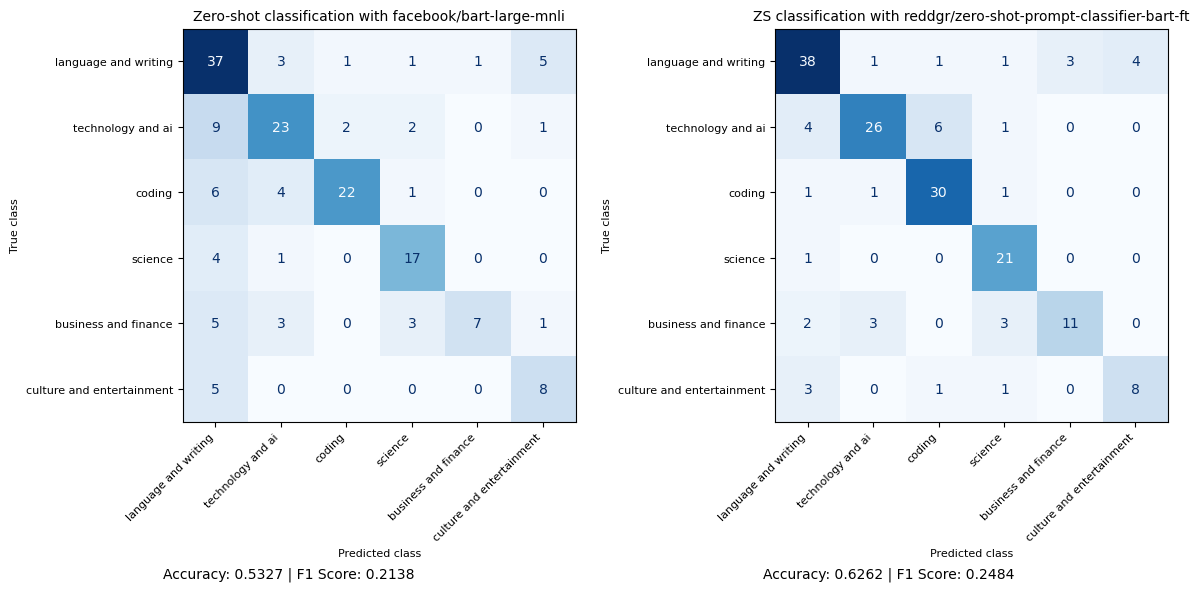

In [22]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()